In [18]:
# import general libraries & data preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# import evaluation metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# import model tuning methods
from sklearn.model_selection import GridSearchCV
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
import hyperopt
from hyperopt.pyll.base import scope 

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping


## 0. Data Preparation

In [19]:
# read data from csv file
df = pd.read_csv('cardio_train_cleaned.csv')

df.head()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,72,1,110,80,1,1,0,0,1,0,21.967
1,67,0,140,90,3,1,0,0,1,1,34.928
2,71,0,130,70,3,1,0,0,0,1,23.508
3,74,1,150,100,1,1,0,0,1,1,28.710
4,75,0,100,60,1,1,0,0,0,0,23.011


In [20]:
# split dataframe into variables and label
X = df.drop('cardio', axis=1)
y = df['cardio']

# split data into train and validation and test
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, stratify=y_rem, random_state=42)

## 1. FNN

In [21]:
# hyperparameter tuning with Hyperopt
def f_nn(params):
    input_shape = X_valid.shape[1]
    
    # Keras FNN model
    model = Sequential()
    model.add(Dense(units=params['units'], input_dim=input_shape, activation='relu'))
    model.add(Dropout(rate=params['rate']))
    
    model.add(Dense(units=params['units'], activation='relu'))
    model.add(Dropout(rate=params['rate']))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    es = EarlyStopping(monitor='val_loss',mode='min',
                       verbose=1,patience=15)
    
    result = model.fit(X_valid, y_valid, 
                       verbose=0, 
                       validation_split=0.1,
                       batch_size=params['batch_size'],
                       epochs=200,
                       callbacks=[es])
    
    # Get the lowest validation loss of the training epochs
    validation_loss = np.amin(result.history['val_loss']) 
    print('Best validation loss of epoch:', validation_loss)
    
    return {'loss': validation_loss, 
            'status': STATUS_OK, 
            'model': model, 
            'params': params}

params = {'rate': hp.uniform('rate',0.0001,0.001),
          'units': scope.int(hp.quniform('units',0,20,2)),
          'batch_size': scope.int(hp.quniform('batch_size',0,100,10)),
        }

trials = Trials()
best_params = fmin(f_nn, 
            params, 
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

Epoch 22: early stopping                                                                                               

Best validation loss of epoch:                                                                                         
0.5682929158210754                                                                                                     
Epoch 25: early stopping                                                                                               

Best validation loss of epoch:                                                                                         
0.6927090287208557                                                                                                     
Epoch 47: early stopping                                                                                               

Best validation loss of epoch:                                                                                         
0.5662453770637512                   

Best validation loss of epoch:                                                                                         
0.5676268339157104                                                                                                     
Epoch 63: early stopping                                                                                               

Best validation loss of epoch:                                                                                         
0.5672880411148071                                                                                                     
Epoch 45: early stopping                                                                                               

Best validation loss of epoch:                                                                                         
0.5659386515617371                                                                                                     
Epoch 47: early stopping              

In [22]:
best_params

{'batch_size': 40.0, 'rate': 0.000966957028267307, 'units': 12.0}

In [23]:
# fit hyperparamater(Hyperopt) and train data into the model
input_shape = X_valid.shape[1]
    
# Keras FNN model
model = Sequential()
model.add(Dense(units=16, input_dim=input_shape, activation='relu'))
model.add(Dropout(rate=best_params['rate']))
    
model.add(Dense(units=best_params['units'], activation='relu'))
model.add(Dropout(rate=best_params['rate']))
    
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
es = EarlyStopping(monitor='val_loss',mode='min',
                       verbose=1,patience=15)
    
result = model.fit(X_train, y_train, 
                       verbose=0, 
                       validation_split=0.1,
                       batch_size=int(best_params['batch_size']),
                       epochs=200,
                       callbacks=[es])


y_pred_train_ = model.predict(X_train)
y_pred_test_ = model.predict(X_test)

# converting predictions to label

# train results
y_pred_train = list()
for i in range(len(y_pred_train_)):
    if y_pred_train_[i] >= 0.5:
        y_pred_train.append(1)
    else:
        y_pred_train.append(0)
        
# test results
y_pred_test = list()
for i in range(len(y_pred_test_)):
    if y_pred_test_[i] >= 0.5:
        y_pred_test.append(1)
    else:
        y_pred_test.append(0)

# evaluation metrics
accuracy = accuracy_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train, average='binary')
recall = recall_score(y_train, y_pred_train, average='binary')
f1 = f1_score(y_train, y_pred_train, average='binary')

print('Train Results')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('f1_score:', f1)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='binary')
recall = recall_score(y_test, y_pred_test, average='binary')
f1 = f1_score(y_test, y_pred_test, average='binary')

print('\nTest Results')
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('f1_score:', f1)




Epoch 141: early stopping
211/211 [==============================] - 0s 1ms/step
Train Results
Accuracy:  0.7268044102659131
Precision:  0.7229724574654764
Recall:  0.7169825596791889
f1_score: 0.7199650502402795

Test Results
Accuracy:  0.7233916394900682
Precision:  0.7215033887861984
Recall:  0.7088377723970944
f1_score: 0.7151145038167938


In [24]:
model.summary()

Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_306 (Dense)           (None, 16)                176       
                                                                 
 dropout_204 (Dropout)       (None, 16)                0         
                                                                 
 dense_307 (Dense)           (None, 12)                204       
                                                                 
 dropout_205 (Dropout)       (None, 12)                0         
                                                                 
 dense_308 (Dense)           (None, 1)                 13        
                                                                 
Total params: 393
Trainable params: 393
Non-trainable params: 0
_________________________________________________________________


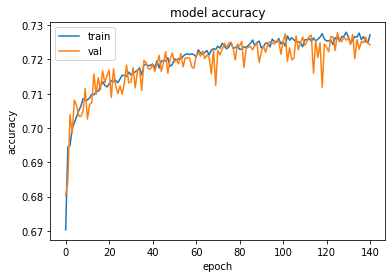

In [25]:
# plot training and validation set accuracy
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

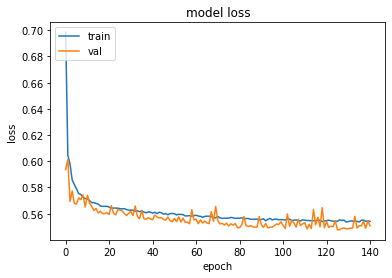

In [26]:
# plot training and validation set model loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Feed forward neural network did not work better than traditional and ensemble methods.